<a href="https://colab.research.google.com/github/filizolalab/CADD2021/blob/main/BSR3101_Tutorial_Predicting_Synthetic_Feasibility_with_SCScore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Predicting Synthetic Feasibility with SCScore

*This tutorial is part of the BSR3101 Computer Aided Drug Design, and is based on the [DeepChem tutorials](https://github.com/deepchem/deepchem/tree/master/examples/tutorials). Also check the [DeepChem website](https://deepchem.io/) for other tutorials and documentation.*

### Background
Synthetic feasibility is a problem when running large scale enumerations.  Often molecules that are enumerated are very difficult to make and thus not worth inspection, even if their other chemical properties are good in silico.  This tutorial goes through how to train the [ScScore](https://pubs.acs.org/doi/abs/10.1021/acs.jcim.7b00622) model.

The idea of the model is to train on pairs of molecules where one molecule is "more complex" than the other.  The neural network then can make scores which attempt to keep this pairwise ordering of molecules.  The final result is a model which can give a relative complexity of a molecule.






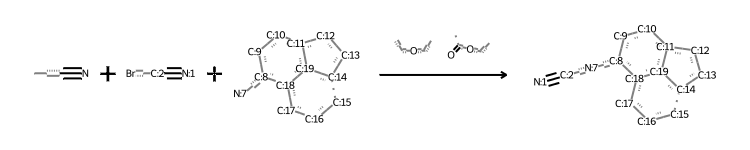

In [100]:

# Let's plot an example of reaction used in the training of the published ScScore network, 
# downloaded from https://github.com/connorcoley/scscore

from rdkit import Chem
from rdkit.Chem import AllChem
reaction_example = 'CC#N.[N:1]#[C:2]Br.[NH2:7][c:8]1[cH:9][cH:10][c:11]2[c:19]3[c:14]([cH:15][cH:16][cH:17][c:18]31)[CH2:13][CH2:12]2>CCOCC.CCOC(C)=O>[N:1]#[C:2][NH:7][c:8]1[cH:9][cH:10][c:11]2[c:19]3[c:14]([cH:15][cH:16][cH:17][c:18]31)[CH2:13][CH2:12]2'
rxn = AllChem.ReactionFromSmarts(reaction_example)
rxn



The paper trains on every reaction in reaxys, declaring products more complex than reactions.  Since this training set is prohibitively expensive we will instead train on arbitrary molecules declaring one more complex if its SMILES string is longer.  In the real world you can use whatever measure of complexity makes sense for the project.

In this tutorial, we'll use the Tox21 dataset to train our simple synthetic feasibility model.


## Install and import `deepchem`

To run this tutorial the machine where the calculations are executed must have a copy of the deepchem libarary installed. If you're running this on a machine where this is not the case, the library can be installed with the following `pip` command You can of course run this tutorial *locally* if you prefer. In 
this case, don't run the `pip install` cell since it will download and install Anaconda on your local machine. 



In [ ]:
!pip install --pre deepchem
import deepchem as dc
dc.__version__

     |████████████████████████████████| 609 kB 8.2 MB/s 
     |████████████████████████████████| 20.6 MB 5.3 MB/s 


'2.6.0.dev'

# Prepare the training dataset

For simplicity, we use the Tox21 database; we will not be using any information about toxicity, just the collection of molecules (their SMILES repsresentation). We specify `splitter=None` so that will be returned as a single dataset; we also specify `featurizer='Raw'` so that the molecules will not be further featurized for the moment.

In [ ]:
tasks, datasets, transformers = dc.molnet.load_tox21(featurizer='Raw', splitter=None)
molecules = datasets[0].X

In [ ]:
## let us have a look at the SMILES of the molecules we retrieved
import pandas as pd
pd.DataFrame(datasets[0].ids, columns=['SMILES'])

,SMILES
0,CCOc1ccc2nc(S(N)(=O)=O)sc2c1
1,CCN1C(=O)NC(c2ccccc2)C1=O
2,CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]...
3,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C
4,CC(O)(P(=O)(O)O)P(=O)(O)O
...,...
7826,CCOc1nc2cccc(C(=O)O)c2n1Cc1ccc(-c2ccccc2-c2nnn...
7827,CC(=O)[C@H]1CC[C@H]2[C@@H]3CCC4=CC(=O)CC[C@]4(...
7828,C[C@]12CC[C@H]3[C@@H](CCC4=CC(=O)CC[C@@]43C)[C...
7829,C[C@]12CC[C@@H]3c4ccc(O)cc4CC[C@H]3[C@@H]1CC[C...


ScScore is trained on *relative* complexities, we want the input data for out neural network (the `X` tensor in our dataset) to have 3 dimensions `(sample_id, molecule_id, features)`:  
* `sample_id` is the number of pairs we are training on
* `molecule_id` is 2, the number of molecules in each pair
*  `features` is the number of features in the rapresentation of the molecule. Here we will use 1024-bit fingerprints

The label (the `y` tensor in our dataset) is 1 if the first molecule is more complex than the second molecule. 

The function `create_dataset` we introduce below pulls random pairs of SMILES strings out of a given list and ranks them according to this complexity measure. In the original paper, the complexity measure is ,
(you could use purchase cost, ...) 
Here, we'll featurize all our molecules with the ECFP fingerprint with chirality (matching the source paper), and will then construct our pairwise dataset using the function defined above.

In [ ]:
import random
from deepchem.feat import CircularFingerprint
import numpy as np

# define the fingerprint length
n_features = 1024
featurizer = dc.feat.CircularFingerprint(size=n_features, radius=2, chiral=True)



def create_dataset(molecules, ds_size=100000):

    ## calculate the fingerprints and the smiles lenghts for all the molecules
    features = featurizer.featurize(molecules)
    smiles_strings = [Chem.MolToSmiles(x) for x in molecules]
    smiles_lens = [len(x) for x in smiles_strings]

    ## pick random pairs of molecules and classify them based on their SMILES lenghs

    X, y, ids = [], [], []
    all_data = list(zip(features, smiles_lens))
    while len(y) < ds_size:
        i1 = random.randrange(0, len(smiles_lens))
        i2 = random.randrange(0, len(smiles_lens))
        m1 = all_data[i1]
        m2 = all_data[i2]
        if m1[1] == m2[1]:
            continue
        if m1[1] > m2[1]:
            y.append(1.0)
        else:
            y.append(0.0)
        X.append([m1[0], m2[0]])
        ids.append([smiles_strings[i1],smiles_strings[i2]])
    return dc.data.NumpyDataset(
        X=np.array(X), 
        y=np.expand_dims(np.array(y),axis=1), 
        ids=np.array(ids))
    

With our complexity ranker in place we can now construct our dataset. Let's start by randomly splitting the list of molecules into training and test sets, and then applying function we just defined to the training dataset.

In [ ]:
molecule_ds = dc.data.NumpyDataset(np.array(molecules))
splitter = dc.splits.RandomSplitter()
train_mols, test_mols = splitter.train_test_split(molecule_ds)

In [ ]:
train_dataset = create_dataset(train_mols.X,ds_size=20000)

In [ ]:
# let's print out the SMILES of the pairs (first colum and second column of the `ids` array), and the label

pd.DataFrame(
{'SMILES1': train_dataset.ids[:,0],
 'SMILES2': train_dataset.ids[:,1],
 'more_complex': train_dataset.y.flatten()}    
)


,SMILES1,SMILES2,more_complex
0,COC(=O)COc1ccc(Cl)cc1Cl,COc1ccc(-c2nc3cc(C4=NNC(=O)CC4C)ccc3[nH]2)cc1,0.0
1,CC(C)(CO)[C@@H](O)C(=O)NCCCC(=O)[O-].CC(C)(CO)...,CCCCCCCCCCCCCCCC[N+](C)(C)C,1.0
2,O=C(OOC(=O)c1ccccc1)c1ccccc1,O=NN([O-])c1ccccc1,1.0
3,O=c1[nH]c2ccccc2n1CCCN1CCN(C(c2ccccc2)c2ccccc2...,OCCSCSCCO,1.0
4,CC(O)COCC(C)O,CC[C@H](C)[C@@H]1NC(=O)[C@H](Cc2ccc(O)cc2)NC(=...,0.0
...,...,...,...
19995,CCCCn1cc[n+](C)c1.O=S(=O)([O-])C(F)(F)F,O=C(O)C1CCCN1,1.0
19996,CCCCOC(=O)CC(CC(=O)OCCCC)(OC(C)=O)C(=O)OCCCC,O=C([O-])Cc1cccc2ccccc12,1.0
19997,COc1ccc(OC)c(C(O)C(C)N)c1,O=[N+]([O-])[O-].[NH4+],1.0
19998,CCC[N+]1(C)CCCCC1.O=S(=O)([N-]S(=O)(=O)C(F)(F)...,O=C(O)Cc1csc(-c2ccc(Cl)cc2)n1,1.0


Let's plot some of the pairs as 2D structures to see what out training set looks like:

In [ ]:
## import some rdkit functions
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.useBWAtomPalette()

def show_pair(i):
   if train_dataset.y[i]==0:
      labels = ['simpler','more complex']
   else:
      labels = ['more complex','simpler']
   pair_smiles = train_dataset.ids[i]
   molecule_list = [Chem.MolFromSmiles(smiles) for smiles in pair_smiles]
   display(Draw.MolsToGridImage(molecule_list,legends=labels))


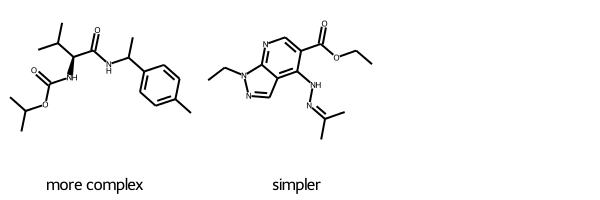

In [ ]:
show_pair(86)

Now that we have our dataset created, let's train a `ScScoreModel` on this dataset.

In [ ]:
model = dc.models.ScScoreModel(n_features=n_features)
model.fit(train_dataset, nb_epoch=20)

0.027058157920837402

# Model Predictions

Lets evaluate how well the model does on our test set. Remember, for this example, the SaScores should track the length of SMILES strings from molecules it has never seen during training.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
mol_scores = model.predict_mols(test_mols.X)
smiles_strings = [Chem.MolToSmiles(x) for x in test_mols.X]
smiles_lengths = [len(x) for x in smiles_strings]


In [ ]:
predictions = pd.DataFrame({
    'SMILES': smiles_strings,
    'complexity': mol_scores,
    'SMILES length': smiles_lengths})

predictions.head()

,SMILES,complexity,SMILES length
0,CCc1cccc(N(C)C(=N)Nc2cccc3ccccc23)c1,4.999998,36
1,C1=CCC(c2ccccc2)CC1,4.910220,19
2,O=C(Cl)c1cccc([N+](=O)[O-])c1,4.999917,29
3,CC1(C)[C@H](C=C(Cl)Cl)[C@@H]1C(=O)O[C@@H](C#N)...,5.000000,65
4,CN(C)c1ccc(C=O)cc1,4.785502,18


Let's have a look at some molecules predicted: 
we can select the rows of the above dataframe as follows:
* simple `predictions.complexity<1.2`
* medium `(predictions.complexity>2.5 ) & (predictions.complexity<3 )`
* complex `predictions.complexity==5`

In [ ]:
def show_list(molecules,n=5):
    molecule_list = [Chem.MolFromSmiles(smiles) for smiles in molecules[:n].SMILES.tolist()]
    complexity_list = [f'complexity: {x:.2f}' for x in  molecules[:n].complexity.tolist()]
    display(Draw.MolsToGridImage(molecule_list,legends=complexity_list))

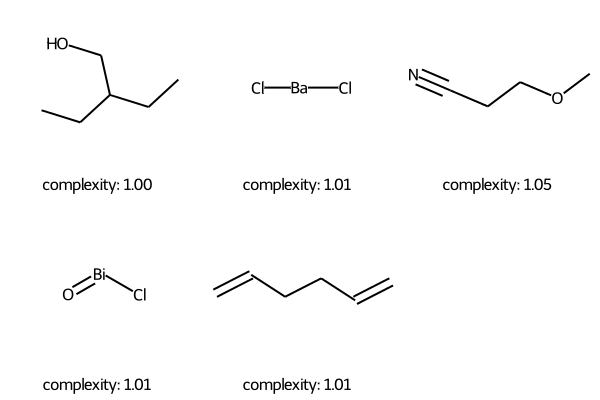

In [ ]:
simple_molecules = predictions.loc[ predictions.complexity<1.2 ]
show_list(simple_molecules,5)

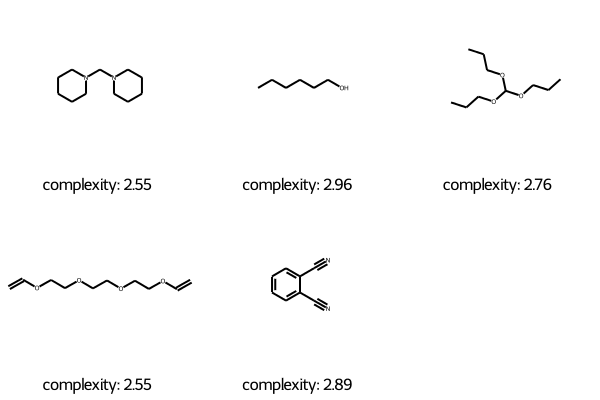

In [ ]:
medium_molecules = predictions.loc[(predictions.complexity>2.5 ) & (predictions.complexity<3 )]
show_list(medium_molecules)


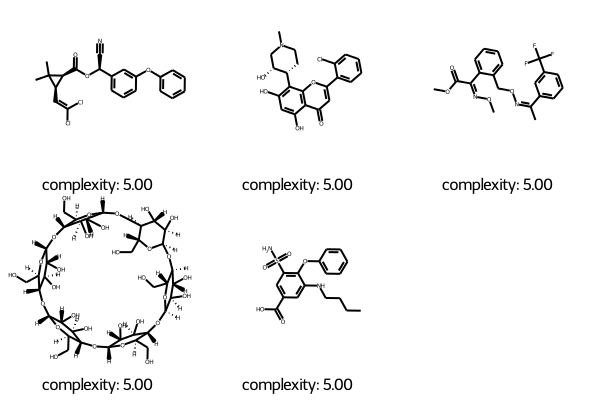

In [ ]:
complex_molecules = predictions.loc[ predictions.complexity==5 ]
show_list(complex_molecules)

### Plot of complexity score vs SMILES length

Let's now plot the length of the smiles string of the molecule against the complexity score. As we can see the model generally tracks SMILES length.  It has good enrichment between 8 and 30 characters and classifies both small and large SMILES strings at the extremes very well.

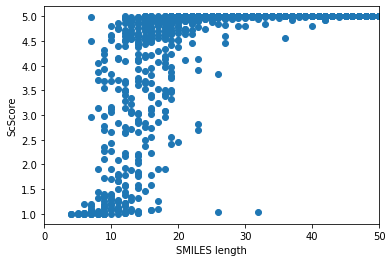

In [ ]:
#plt.figure(figsize=(15,10))
plt.scatter(smiles_lengths, mol_scores)
plt.xlim(0,50)
plt.xlabel("SMILES length")
plt.ylabel("ScScore")
plt.show()

You can now train your own models on more meaningful metrics than SMILES length!

## Done!

You can learn more about DeepChem by checking and following DeepChem on [GitHub](https://github.com/deepchem/deepchem). 
This helps build awareness of the DeepChem project and the tools for open source drug discovery that we're trying to build.